In [1]:
!nvidia-smi

Mon Dec  9 20:54:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="92jyh8UFL7X56QYAPtge")
project = rf.workspace("roboflow-100").project("axial-mri")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


In [3]:
!ls

axial-MRI-1  sample_data


In [4]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-slhees7i
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-slhees7i
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done


In [5]:
import os
import json
import cv2
import random
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


In [6]:
data_dir = "./axial-MRI-1"
train_json = os.path.join(data_dir, "train", "_annotations.coco.json")
val_json = os.path.join(data_dir, "valid", "_annotations.coco.json")
train_img_dir = os.path.join(data_dir, "train")
val_img_dir = os.path.join(data_dir, "valid")

# Register the datasets
register_coco_instances("mri_train", {}, train_json, train_img_dir)
register_coco_instances("mri_val", {}, val_json, val_img_dir)

mri_metadata = MetadataCatalog.get("mri_train")
dataset_dicts = DatasetCatalog.get("mri_train")
print("Number of training images:", len(dataset_dicts))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Number of training images: 253


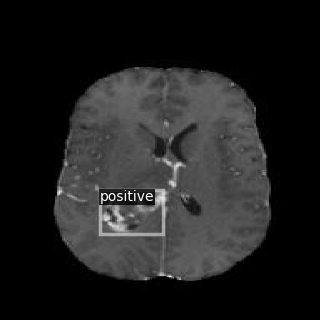

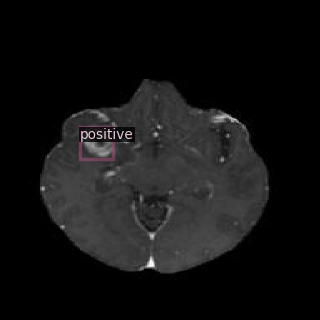

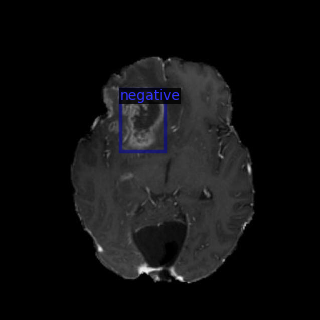

In [7]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=mri_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [10]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mri_train",)
cfg.DATASETS.TEST = ("mri_val",)
cfg.DATALOADER.NUM_WORKERS = 2

# Pretrained weights from COCO
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 0.00025  # may adjust
cfg.SOLVER.MAX_ITER = 3000    # may adjust depending on dataset size
cfg.SOLVER.STEPS = []         # no LR step downs by default

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # default 512, can adjust
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # we have "negative" and "positive"

cfg.OUTPUT_DIR = "./output_mri"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [11]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/09 20:56:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/09 20:56:31 d2.engine.train_loop]: Starting training from iteration 0
[12/09 20:56:39 d2.utils.events]:  eta: 0:20:20  iter: 19  total_loss: 1.421  loss_cls: 1.069  loss_box_reg: 0.2799  loss_rpn_cls: 0.01899  loss_rpn_loc: 0.004982    time: 0.4110  last_time: 0.4097  data_time: 0.0254  last_data_time: 0.0198   lr: 4.9953e-06  max_mem: 2875M
[12/09 20:56:49 d2.utils.events]:  eta: 0:20:52  iter: 39  total_loss: 1.144  loss_cls: 0.9393  loss_box_reg: 0.1535  loss_rpn_cls: 0.02751  loss_rpn_loc: 0.005225    time: 0.4236  last_time: 0.3951  data_time: 0.0234  last_data_time: 0.0196   lr: 9.9902e-06  max_mem: 2877M
[12/09 20:56:59 d2.utils.events]:  eta: 0:20:56  iter: 59  total_loss: 0.9196  loss_cls: 0.7137  loss_box_reg: 0.1768  loss_rpn_cls: 0.01801  loss_rpn_loc: 0.004431    time: 0.4437  last_time: 0.8571  data_time: 0.0340  last_data_time: 0.1558   lr: 1.4985e-05  max_mem: 2877M
[12/09 20:57:08 d2.utils.events]:  eta: 0:20:47  iter: 79  total_loss: 0.8016  loss_cls: 0.4899  loss

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a threshold for inference
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("mri_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "mri_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[12/09 21:19:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_mri/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


WARNING [12/09 21:19:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/09 21:19:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 21:19:19 d2.data.datasets.coco]: Loaded 79 images in COCO format from ./axial-MRI-1/valid/_annotations.coco.json
[12/09 21:19:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/09 21:19:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/09 21:19:19 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[12/09 21:19:19 d2.data.common]: Serialized dataset takes 0.02 MiB
[12/09 21:19:19 d2.evaluation.evaluator]: Start inference on 79 batches
[12/09 21:19:20 d2.evaluation.ev

WARNING [12/09 21:19:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 21:19:44 d2.data.datasets.coco]: Loaded 79 images in COCO format from ./axial-MRI-1/valid/_annotations.coco.json


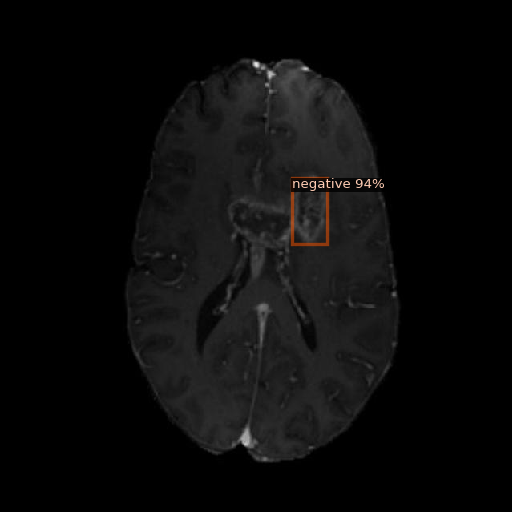

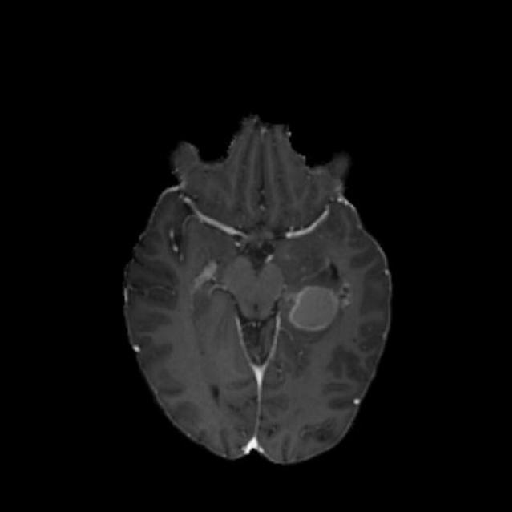

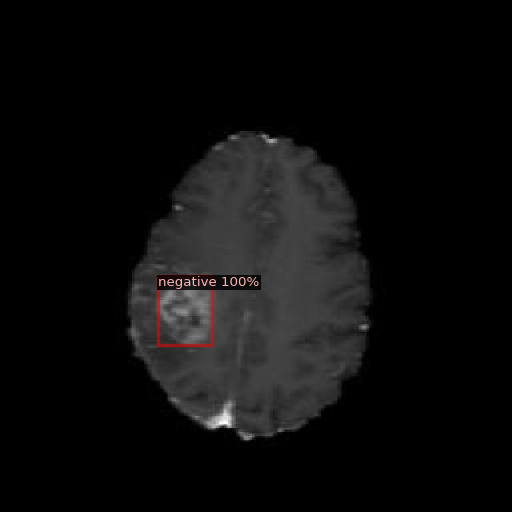

In [13]:
dataset_dicts_val = DatasetCatalog.get("mri_val")

for d in random.sample(dataset_dicts_val, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=mri_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
